In [1]:
# @title import
import functools

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(font_scale=1.4, style="white")
sns.set_palette("tab10")

In [ ]:
# @title Helper Functions for Linear Regression
def generate_linear(num_data, dimension, num_workers, noise_level):
    """Generates N data pairs (A_i, b_i) of dimension d that follow a linear
    regression model.
    """
    A = np.diag((np.random.rand(num_data) + 1) / 2) @ np.random.randn(num_data, dimension)
    x_o = np.random.randn(dimension, 1)
    ns = noise_level * np.random.randn(num_data, 1)
    b = A.dot(x_o) + ns

    x_opt = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)

    As = []
    bs = []
    for i in range(num_workers):
        As.append(A[i::num_workers])
        bs.append(b[i::num_workers])
    return As, bs, x_opt


def grad_fn_agent_all(X, Aarr, barr):
    # We assume X contains all agent's info. The i-th column of X is the x of i-th agent.
    # Aarr is [A0, A1, ..., AN], and barr is [b0, ..., bN].
    num_dim, num_works = X.shape
    grad = np.zeros_like(X)
    for i in range(num_works):
        A = Aarr[i]
        b = barr[i]
        grad[:, [i]] = A.T.dot(A.dot(X[:, [i]]) - b)
    return grad

In [4]:
# @title Helper functions for Logistic regressions
def generate_logistic(num_data, dimension, num_workers):
    """Generates N data pairs (gamma,h) that follow a logistic model with
    parameter wo of size Mx1  and offset theta. The feature vectors
    are Gaussian distributed.

    Offset parameter theta should be small, say, p=0.1 or smaller, to
    help ensure p close to 0.5
    """
    A = np.diag((np.random.rand(num_data) + 1) / 2) @ np.random.randn(num_data, dimension)
    x_o = np.random.randn(dimension, 1)

    px = 1 / (1 + np.exp(-A.dot(x_o)))  # probability of gamma = +1;
    x = np.random.rand(num_data, 1)
    b = 2 * (x <= px) - 1

    As = []
    bs = []
    for i in range(num_workers):
        As.append(A[i::num_workers])
        bs.append(b[i::num_workers])
    return As, bs, A, b, x_o  # Note x_o is not optimal solution


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def grad_of_logistic(w, gamma, H):
    assert set(gamma.ravel().tolist()).issubset({1, -1})
    N, M = H.shape
    return -(gamma * H).T @ sigmoid(-gamma * H @ w) / N


def loss_of_logisitc(w, gamma, H):
    return np.mean(np.log(1 + np.exp(-gamma * H @ w)))

In [5]:
# @title Generate Data
num_data = 500  # @param
dimension = 50  # @param
num_workers = 16  # @param
noise_level = 0.1  # @param
max_iters = 500  # @param

np.random.seed(1234)
As, bs, x_opt = generate_linear(num_data * num_workers, dimension, num_workers, noise_level)

/var/folders/y9/2rl_p0fx2_d97f8j1sz6f80r00c2js/T/ipykernel_38597/430693717.py:8: RuntimeWarning: divide by zero encountered in matmul
  A = np.diag((np.random.rand(num_data) + 1) / 2) @ np.random.randn(num_data, dimension)
/var/folders/y9/2rl_p0fx2_d97f8j1sz6f80r00c2js/T/ipykernel_38597/430693717.py:8: RuntimeWarning: overflow encountered in matmul
  A = np.diag((np.random.rand(num_data) + 1) / 2) @ np.random.randn(num_data, dimension)
/var/folders/y9/2rl_p0fx2_d97f8j1sz6f80r00c2js/T/ipykernel_38597/430693717.py:8: RuntimeWarning: invalid value encountered in matmul
  A = np.diag((np.random.rand(num_data) + 1) / 2) @ np.random.randn(num_data, dimension)


In [ ]:
class FedASLClient:
    def __init__(self, A, b, dimension, eta, client_idx):
        self.x = np.zeros([dimension, 1])
        self.y = np.zeros([dimension, 1])
        self.grad_fn = lambda x: A.T.dot(A.dot(x) - b)
        self.grad_curr = None
        self.grad_prev = np.zeros([dimension, 1])
        self.eta = eta
        self.noise_level = 0
        self.client_idx = client_idx

    def pull_model(self, x):
        self.x = x.copy()

    def local_update(self, K, if_sampled=True):
        self.y = 0 if if_sampled else self.y
        for k in range(K):
            if k > 0:
                self.x = self.x - self.eta * self.y
            self.grad_curr = (
                self.grad_fn(self.x) + np.random.randn(*self.x.shape) * self.noise_level
            )
            self.y = self.y + self.grad_curr - self.grad_prev
            self.grad_prev = self.grad_curr

    def push_grad(self):
        return self.y

In [17]:
class FedProxClient:
    def __init__(self, A, b, dimension, eta, client_idx):
        self.x = np.zeros([dimension, 1])
        # For prox_{mu.f} = argmin 0.5*\|Ax-b\|^2 + \mu/2\|x-x^t\|^2
        #    A^T(Ax-b) + mu(x-x^t) = 0
        # ==> (A^TA + mu I) x - A^T*b - mu x^t = 0
        # ==> x = (A^TA + mu I)^{-1} (mu x^t + A^T*b)
        # ==> x = (I + A^TA /mu)^{-1} (x^t + A^T*b / mu)
        self.prox_step = lambda x: np.linalg.inv(np.eye(dimension) + A.T @ A * self.eta) @ (
            x + A.T.dot(b) * self.eta
        )
        self.eta = eta
        self.client_idx = client_idx

    def pull_model(self, x):
        self.x = x.copy()

    def local_update(self, K):
        del K  # no need to use
        self.x = self.prox_step(self.x)

    def push_model(self):
        return self.x

In [18]:
class FedAvgClient:
    def __init__(self, A, b, dimension, eta, client_idx):
        self.x = np.zeros([dimension, 1])
        self.grad_fn = lambda x: A.T.dot(A.dot(x) - b)
        self.eta = eta
        self.client_idx = client_idx

    def pull_model(self, x):
        self.x = x.copy()

    def local_update(self, K):
        for k in range(K):
            self.x = self.x - self.eta * self.grad_fn(self.x)

    def push_model(self):
        return self.x

In [19]:
class ScaffoldClient:
    def __init__(self, A, b, dimension, eta, client_idx):
        self.x = np.zeros([dimension, 1])
        self.grad_fn = lambda x: A.T.dot(A.dot(x) - b)
        self.eta = eta
        self.local_c = 0
        self.delta_c = 0
        self.client_idx = client_idx

    def pull_model(self, x):
        self.x = x.copy()

    def local_update(self, K, global_c):
        init_model = self.x.copy()
        for k in range(K):
            self.x = self.x - self.eta * (self.grad_fn(self.x) - self.local_c + global_c)

        self.delta_model = self.x - init_model
        self.delta_c = -global_c - self.delta_model / (K * self.eta)  # option 2
        # self.delta_c =  self.grad_fn(init_model) - self.local_c  # option 1
        self.local_c += self.delta_c

    def push_model(self):
        return self.delta_model, self.delta_c

In [20]:
class FedAUClient:
    def __init__(self, A, b, dimension, eta, client_idx):
        self.x = np.zeros([dimension, 1])
        self.x_prev = self.x.copy()
        self.delta_model = None
        self.grad_fn = lambda x: A.T.dot(A.dot(x) - b)
        self.eta = eta
        self.K = 10
        self.participation_counter = 0  # M_n
        self.weight = 1.0
        self.total_intervals = 0  # S*_n

        self.client_idx = client_idx

    def pull_model(self, x):
        self.x = x.copy()

    def local_update(self, K):
        init_model = self.x.copy()
        for k in range(K):
            self.x = self.x - self.eta * self.grad_fn(self.x)
        self.delta_model = self.x - init_model

    def push_model(self):
        return self.delta_model, self.weight

    def update_weight(self, participated):
        self.total_intervals += 1
        if participated == 1 or self.total_intervals == self.K:
            S_n = self.total_intervals
            if self.participation_counter == 0:
                self.weight = S_n
            else:
                self.weight = (self.participation_counter * self.weight + S_n) / (
                    self.participation_counter + 1
                )
            self.participation_counter += 1
            self.total_intervals = 0
        else:
            pass

In [21]:
class ProxSkipClient:
    def __init__(self, A, b, dimension, eta, client_idx):
        self.x = np.zeros([dimension, 1])
        self.x_prev = self.x.copy()
        self.grad_fn = lambda x: A.T.dot(A.dot(x) - b)
        self.h = 0
        self.eta = eta
        self.client_idx = client_idx

    def pull_model(self, x):
        self.x_prev = self.x
        self.x = x.copy()

    def local_update(self, K):
        self.h = self.h + (self.x - self.x_prev) / (self.eta * K)
        for k in range(K):
            self.x = self.x - self.eta * (self.grad_fn(self.x) - self.h)

    def push_model(self):
        return self.x

In [73]:
class MIFA:
    def __init__(self, A, b, dimension, eta, client_idx):
        self.x = np.zeros([dimension, 1])
        self.grad_fn = lambda x: A.T.dot(A.dot(x) - b)
        self.eta = eta
        self.x_prev = None
        self.client_idx = client_idx

    def pull_model(self, x):
        self.x_prev = self.x.copy()
        self.x = x.copy()

    def local_update(self, K):
        for k in range(K):
            self.x = self.x - self.eta * self.grad_fn(self.x)

    def push_model(self):
        return self.x_prev - self.x, self.client_idx

# Run exeperiment


In [87]:
ALG_MAP = {
    "FedASL": FedASLClient,
    "FedAvg": FedAvgClient,
    # "FedProx": FedProxClient,
    "FedAU": FedAUClient,
    "Scaffold": ScaffoldClient,
    "ProxSkip": ProxSkipClient,
    "MIFA": MIFA,
}


def run_exp(alg, K, sampling_method, eta, iters=1000, update_eta_func=lambda eta, k: eta):
    mse = []
    x_serv = np.zeros([dimension, 1])
    y_serv = np.zeros([dimension, 1])  # FedASL only
    global_c = 0  # scaffold only
    server_g = np.zeros([dimension, num_workers])  # MIFA only
    clients = [
        ALG_MAP[alg](A, b, dimension=dimension, eta=eta, client_idx=i)
        for i, (A, b) in enumerate(zip(As, bs))
    ]
    mse.append(np.linalg.norm(x_serv - x_opt) / np.linalg.norm(x_opt))

    for iter in range(iters):
        sampled_clients = sampling_method(clients)
        if alg == "FedASL":
            for client in sampled_clients:
                client.eta = update_eta_func(eta, iter)
                client.pull_model(x_serv)
                client.local_update(K=K)
                y_serv += client.push_grad()

            x_serv = x_serv - eta * y_serv

        elif alg in ("FedAvg", "FedProx", "ProxSkip"):
            for client in sampled_clients:
                client.eta = update_eta_func(eta, iter)
                client.pull_model(x_serv)
                client.local_update(K=K)

            x_serv = 0
            for client in sampled_clients:
                x_serv += client.push_model()
            x_serv /= len(sampled_clients)

        elif alg == "Scaffold":
            for client in sampled_clients:
                client.pull_model(x_serv)
                client.local_update(K=K, global_c=global_c)

            for client in sampled_clients:
                client_delta_model, delta_c = client.push_model()
                x_serv += client_delta_model / len(sampled_clients)
                global_c += delta_c * (1 / len(clients))

        elif alg == "FedAU":
            for client in sampled_clients:
                client.eta = update_eta_func(eta, iter)
                client.pull_model(x_serv)
                client.local_update(K=K)

            for client in clients:
                if client in sampled_clients:
                    client.update_weight(participated=1)
                else:
                    client.update_weight(participated=0)

            delta_sum = 0
            total_weight = 0
            for client in sampled_clients:
                delta, weight = client.push_model()
                delta_sum += weight * delta
                total_weight += weight

            x_serv += delta_sum / total_weight

        elif alg == "MIFA":
            for client in sampled_clients:
                client.pull_model(x_serv)
                client.local_update(K=K)

            for client in sampled_clients:
                client_delta_model, client_index = client.push_model()
                server_g[:, [client_index]] = client_delta_model.copy()
            x_serv -= np.mean(server_g, axis=1, keepdims=True)

        else:
            raise ValueError(f"Unknown {alg=}")

        mse.append(np.linalg.norm(x_serv - x_opt) / np.linalg.norm(x_opt))
    return mse

In [89]:
def uniform_sampling_method(clients, size):
    return np.random.choice(clients, size=size, replace=False)


def arb_sampling_method(clients, size, prob):
    return np.random.choice(clients, size=size, replace=False, p=prob)


def arb_participate_method(clients, prob):
    sampled_index = []
    while len(sampled_index) == 0:
        sampled_index = np.arange(len(clients))[np.random.rand(len(clients)) < prob]
    sampled_clients = [clients[int(i)] for i in sampled_index]
    return sampled_clients


def full_sampling_method(clients):
    return clients

In [90]:
mse_dict2 = {}
for alg in ALG_MAP:
    mse_dict2[alg] = run_exp(alg, K=3, sampling_method=full_sampling_method, eta=0.0006, iters=500)

mse_dict3 = {}
for alg in ALG_MAP:
    mse_dict3[alg] = run_exp(
        alg,
        K=3,
        sampling_method=functools.partial(uniform_sampling_method, size=4),
        eta=0.00015,
        iters=500,
    )

mse_dict4 = {}
np.random.seed(5)
prob = np.random.rand(len(As)) + 0.01
prob /= sum(prob)
for alg in ALG_MAP:
    mse_dict4[alg] = run_exp(
        alg,
        K=3,
        sampling_method=functools.partial(arb_sampling_method, size=4, prob=prob),
        eta=0.0001,
        iters=500,
    )

Text(0, 0.5, '$q_i$')

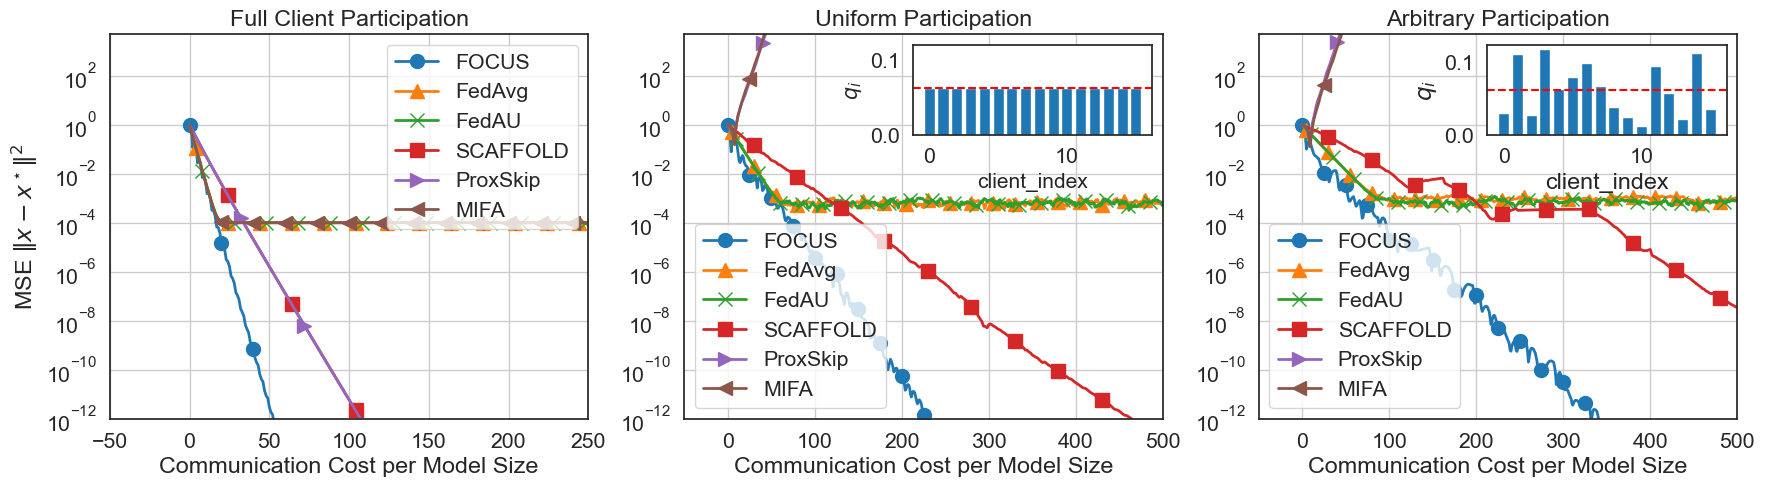

In [91]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def map_name(name):
    if name == "Scaffold":
        return "SCAFFOLD"
    if name == "FedASL":
        return "FOCUS"
    return name


# Make all plots together
fig = plt.figure(figsize=(21, 5))
ax1, ax2, ax3 = fig.subplots(1, 3)
markers = "o^xs><"
# Plot 1
for i, (name, mse) in enumerate(mse_dict2.items()):
    factor = 2 if name in ("Scaffold", "ProxSkip") else 1
    ax1.semilogy(
        np.arange(len(mse)) * factor,
        mse,
        label=map_name(name),
        marker=markers[i],
        markevery=(i * 4, 20),
        markersize=10,
        linewidth=2,
    )
ax1.legend(loc=1)
ax1.set_xlim(-50, 250)
ax1.set_ylim(1e-12, 5e3)
ax1.grid(True)
ax1.set_title("Full Client Participation")
ax1.set_xlabel("Communication Cost per Model Size")
ax1.set_ylabel("MSE $\|x-x^\star\|^2$")

# Plot 2
for i, (name, mse) in enumerate(mse_dict3.items()):
    factor = 2 if name in ("Scaffold", "ProxSkip") else 1
    ax2.semilogy(
        np.arange(len(mse)) * factor,
        mse,
        label=map_name(name),
        marker=markers[i],
        markevery=(i * 5, 25),
        markersize=10,
        linewidth=2,
    )
ax2.legend(loc=3)
ax2.set_xlim(-50, 500)
ax2.set_ylim(1e-12, 5e3)
ax2.grid(True)
ax2.set_title("Uniform Participation")
ax2.set_xlabel("Communication Cost per Model Size")
# ax2.set_ylabel("MSE $\|x-x^\star\|^2$")
ins = inset_axes(
    ax2,
    width="50%",  # width = 30% of parent_bbox
    height=0.9,  # height : 1 inch
    loc=1,
)

ins.bar(np.arange(num_workers), 1 / num_workers)
ins.axhline(y=1 / num_workers, color="red", linestyle="--")
ins.set_ylim(0, 0.12)
ins.set_xlabel("client_index", fontsize=15)
ins.set_ylabel("$q_i$", fontsize=15)

# Plot 3
for i, (name, mse) in enumerate(mse_dict4.items()):
    factor = 2 if name in ("Scaffold", "ProxSkip") else 1
    ax3.semilogy(
        np.arange(len(mse)) * factor,
        mse,
        label=map_name(name),
        marker=markers[i],
        markevery=(i * 5, 25),
        markersize=10,
        linewidth=2,
    )
ax3.legend(loc=3)
ax3.set_xlim(-50, 500)
ax3.set_ylim(1e-12, 5e3)
ax3.grid(True)
ax3.set_title("Arbitrary Participation")
ax3.set_xlabel("Communication Cost per Model Size")
# ax3.set_ylabel("MSE $\|x-x^\star\|^2$")
ins = inset_axes(
    ax3,
    width="50%",  # width = 30% of parent_bbox
    height=0.9,  # height : 1 inch
    loc=1,
)

ins.bar(np.arange(len(prob)), prob)
ins.axhline(y=1 / len(prob), color="red", linestyle="--")
ins.set_xlabel("client_index")
ins.set_ylabel("$q_i$")